In [3]:
import pandas as pd

df = pd.read_csv("./time_series_demo/book_sales.csv", index_col='Date', parse_dates=['Date']).drop('Paperback', axis=1)

In [4]:
df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


In [5]:
import numpy as np

In [6]:
# Time step dummy uses arange and length of the index
df['Time'] = np.arange(len(df.index))

In [7]:
df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

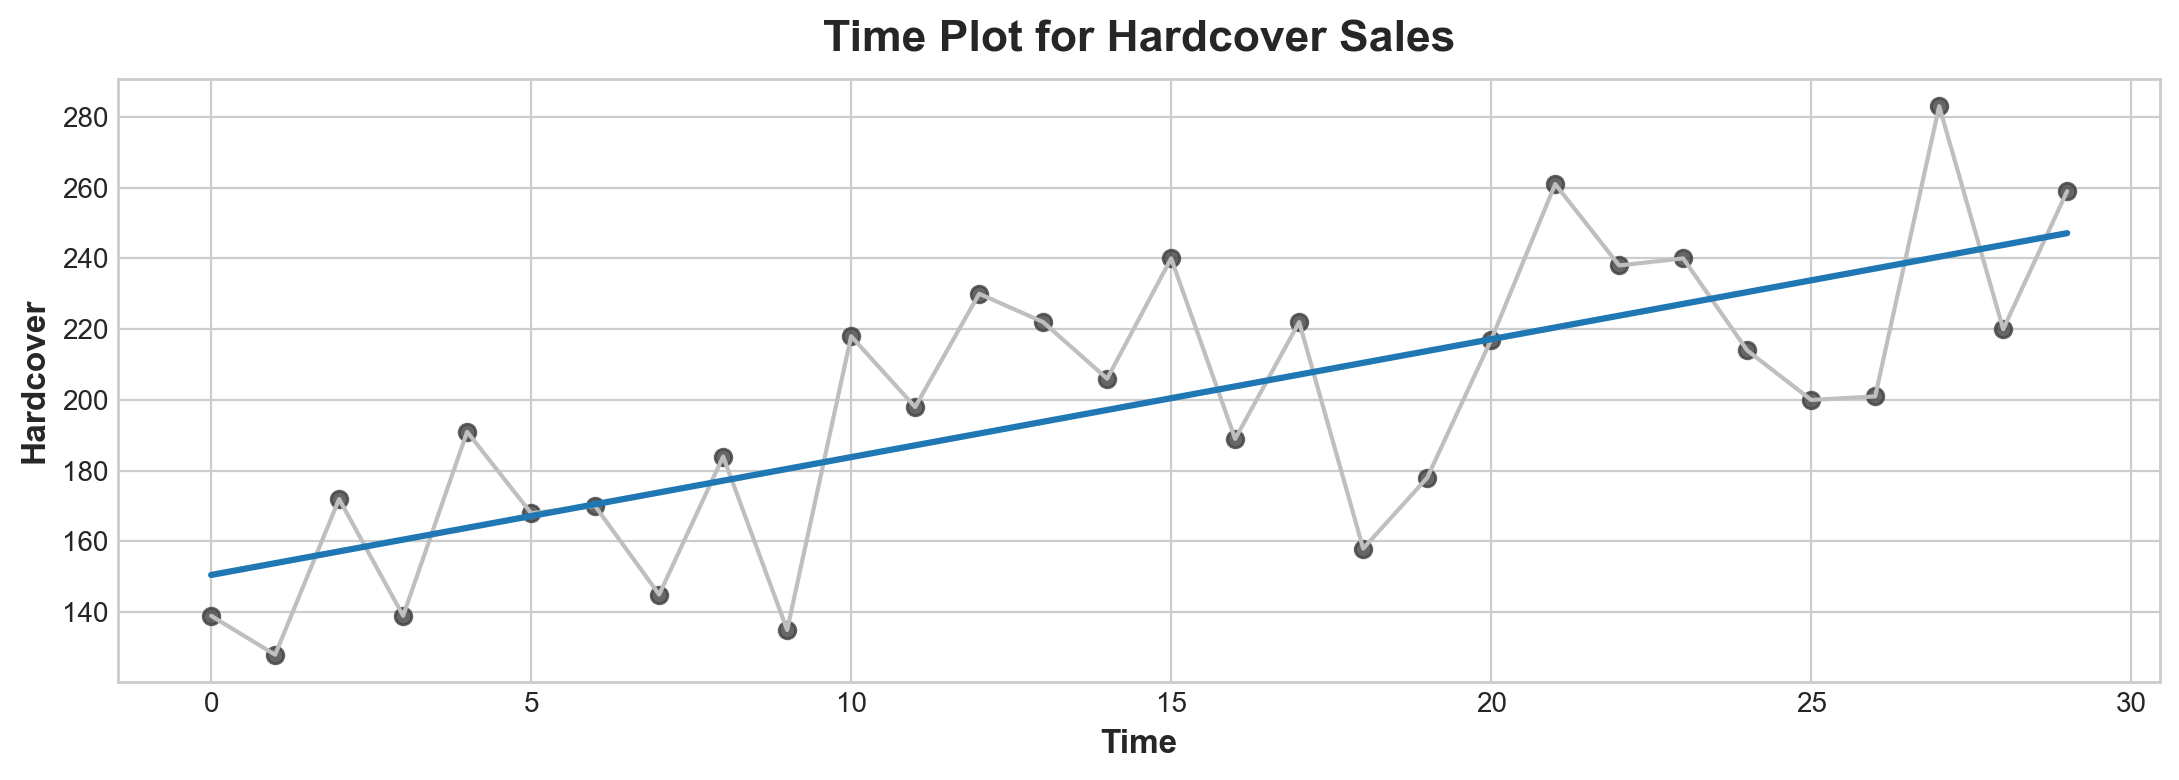

In [14]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot for Hardcover Sales');